# Volumetrics and units

We'll implement the volumetric equation:

$$ V = A \times T \times G \times \phi \times N\!\!:\!\!G \times S_\mathrm{O} \times \frac{1}{B_\mathrm{O}} $$

We'll also look at a package for handling units, and briefly at Monte Carlo simulation of prospects.

## Gross rock volume 

$$ \mathrm{GRV} = A \times T $$

In [1]:
thick = 80            # metres
area = 20000 * 30000  # metres

grv = thick * area
grv

48000000000

Wouldn't it be cool if we could carry units around with our calculations? With [`pint`](https://pint.readthedocs.io/en/latest/index.html), we can!

In [5]:
import pint

unit = pint.UnitRegistry()

thick = 80 * unit.m
area = 20000 * unit.m * 30000 * unit.m
grv = thick * area
grv

48000000000 <Unit('meter ** 3')>

Make a <bold>function</bold> that computes the GRV.

In [6]:
def calculate_grv(thickness, area):
    return thickness * area

Now we can just call this function, instead of remembering the equation. (Admittedly, the equation is rather easy to remember in this case!)

In [7]:
calculate_grv(thick, area)

48000000000 <Unit('meter ** 3')>

It works!

Now we need to compensate for the prospect not being a flat slab of rock &mdash; using the geometric factor. 

We will implement the equations implied by this diagram:

<html>
    <img src="http://subsurfwiki.org/images/6/66/Geometric_correction_factor.png", width=600>
</html>

In [8]:
top = input("What shape is the prospect? ")

What shape is the prospect? 


In [9]:
height = 100 * unit.m
ratio = thick / height

if top == 'round':
    g = -0.6 * ratio + 1

if top == 'flat':
    g = -0.3 * ratio + 1

if top == 'slab':
    g = 1

g

NameError: name 'g' is not defined

### Exercise

Turn this one into a function.

In [10]:
def geometric_factor(thick, height, top='slab'):

    # Your code here
    
    return g

In [11]:
def geometric_factor(thick, height, top='slab'):

    ratio = thick / height

    if top == 'round':
        g = -0.6 * ratio + 1
    elif top == 'flat':
        g = -0.3 * ratio + 1
    else:
        g = 1

    return g

In [12]:
geometric_factor(thick, height=100*unit.m, top='round')

0.52 <Unit('dimensionless')>

In [13]:
grv *= g

NameError: name 'g' is not defined

What if we have multiple prospects?

In [14]:
import numpy as np

thicknesses = np.array([10, 25, 15, 5, 100]) * unit.m
heights = np.array([75, 100, 20, 100, 200]) * unit.m

In [15]:
geometric_factor(thicknesses, heights, top='round')

Magnitude,[0.92 0.85 0.55 0.97 0.7]
Units,dimensionless


It works!

## HC pore volume

We need:

- net:gross &mdash; the ratio of reservoir-quality rock thickness to the total thickness of the interval.
- porosity
- $S_\mathrm{O}$ &mdash; the oil saturation, or proportion of oil to total pore fluid.

In [16]:
netg = 0.5   # fraction
por = 0.24   # fraction
s_o = 0.8    # fraction

hcpv = netg * por * s_o
hcpv

0.096

We'll leave that as a fraction for now.

### EXERCISE

- Turn this into a function by rearranging the following lines of code:

In [17]:
"""A function to compute the hydrocarbon pore volume."""
return hcpv
hcpv = netg * por * s_o
def calculate_hcpv(netg, por, s_o):

SyntaxError: unexpected EOF while parsing (<ipython-input-17-0e1bae06c81a>, line 4)

In [18]:
# Put your code here:



In [19]:
def calculate_hcpv(netg, por, s_o):
    """A function to compute the hydrocarbon pore volume."""
    hcpv = netg * por * s_o
    return hcpv

## Formation volume factor

Oil shrinks when we produce it, especially if it has high GOR. The FVF, or $B_O$, is the ratio of a reservoir barrel to a stock-tank barrel (25 deg C and 1 atm). Typically the FVF is between 1 (heavy oil) and 1.7 (high GOR).

In [20]:
fvf = 1.1

### EXERCISE

For gas, $B_\mathrm{G}$ is $0.35 Z T / P$, where $Z$ is the correction factor, or gas compressibility factor. $T$ should be in kelvin and $P$ in kPa. $Z$ is usually between 0.8 and 1.2, but it can be as low as 0.3 and as high as 2.0.

Can you write a function to calculate $B_\mathrm{G}$?

In [21]:
def calculate_Bg(     ):  # Add the arguments.
    """Write a docstring."""
    
    
    return         # Don't forget to return something!

In [22]:
def calculate_Bg(Z=1, T=273.15, P=101.325):
    """
    Compute B_G from correction factor Z, temperature T (K),
    and pressure P (kPa).
    """
    Bg = 0.35 * Z * T / P
    return Bg

In [23]:
calculate_Bg(T=293*unit.K, P=1000*unit.kPa)

0.10255 <Unit('kelvin / kilopascal')>

## Put it all together

Now we have the components of the volumetric equation:

In [24]:
hcip = grv * hcpv / fvf
hcip

4189090909.0909085 <Unit('meter ** 3')>

Pint can convert to other units, e.g. Imperial barrels, for us.

In [25]:
hcip.to('imperial_barrel')

25596421620.257477 <Unit('imperial_barrel')>

An Imperial barrel is 43 gallons ([Wikipedia](https://en.wikipedia.org/wiki/Barrel_(unit)), whereas an oil barrel is only 42 gallons. [For more on conversion to bbl, BOE, etc.](https://en.wikipedia.org/wiki/Barrel_of_oil_equivalent).

So let's define a custom unit:

In [26]:
unit.define('oil_barrel = 42 gallon = bbl')

In [27]:
hcip.to('bbl')

26348589118.31922 <Unit('oil_barrel')>

### EXERCISE

Can you write a function to compute the volume (i.e. the HCIP), given all the inputs?

Try to use the functions you have already written.

In [28]:
# Put your code here.


    

In [29]:
# Solution.
def calculate_hcip(thickness, area, height, top, netg, por, s_o, fvf):
    grv = calculate_grv(thickness, area)
    g = geometric_factor(thickness, height, top)
    grv *= g
    hcpv = calculate_hcpv(netg, por, s_o)
    return grv * hcpv / fvf

In [30]:
calculate_hcip(thick, area, height, top, netg, por, s_o, fvf)

4189090909.0909085 <Unit('meter ** 3')>

## Monte Carlo simulation

We can easily draw randomly from distributions of properties:

- Normal: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html
- Uniform: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.uniform.html
- Lognormal: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.lognormal.html

In [31]:
import numpy as np

netg = np.random.normal(loc=0.5, scale=0.1, size=100)
por = np.random.normal(loc=0.15, scale=0.025, size=100)

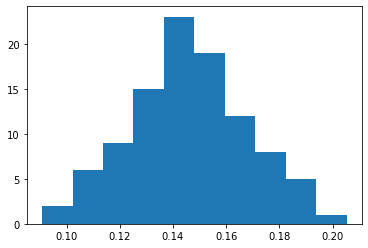

In [32]:
import matplotlib.pyplot as plt

_ = plt.hist(por)

/Users/matt/opt/miniconda3/envs/geocomp/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/matt/opt/miniconda3/envs/geocomp/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

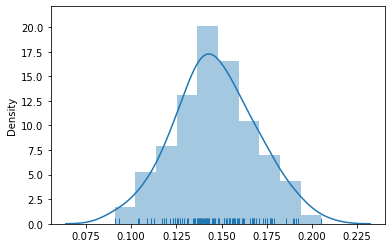

In [33]:
import seaborn as sns

sns.distplot(por, rug=True)

In [34]:
hcpv = calculate_hcpv(netg, por, s_o)
hcpv

array([0.04427712, 0.06236849, 0.04296027, 0.03368466, 0.07071386,
       0.0498602 , 0.05846551, 0.04320051, 0.06822684, 0.06379743,
       0.05835895, 0.08465344, 0.04534658, 0.05767118, 0.056044  ,
       0.04712785, 0.0574098 , 0.06565881, 0.07556812, 0.06441453,
       0.07853891, 0.05490625, 0.02547876, 0.06283608, 0.05761926,
       0.05352282, 0.06288085, 0.06073618, 0.04597958, 0.04611274,
       0.04818464, 0.04942944, 0.03978203, 0.07355209, 0.04204813,
       0.05286646, 0.05574991, 0.05448392, 0.05387353, 0.05848949,
       0.05698897, 0.05863015, 0.06458509, 0.04572697, 0.04600483,
       0.08663773, 0.07689846, 0.03694795, 0.06053895, 0.09323866,
       0.08867808, 0.05187191, 0.06056986, 0.06170616, 0.04663036,
       0.05355935, 0.02285901, 0.05778476, 0.0567655 , 0.06723879,
       0.051292  , 0.05291846, 0.06656947, 0.07071494, 0.04406005,
       0.04647503, 0.08707861, 0.05381401, 0.04693957, 0.03176119,
       0.06348392, 0.04982301, 0.05629426, 0.06869865, 0.05670

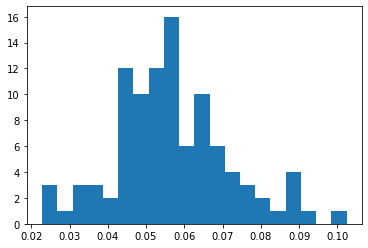

In [35]:
_ = plt.hist(hcpv, bins=20)

In [36]:
hcpv.mean()

0.056981872920069704

The histogram looks a bit ragged, but this is probably because of the relatively small number of samples.

### EXERCISE

1. Compute HCIP with these distributions. Make a histogram of the result in millions of barrels.
1. How does the histogram look if you take 1000 samples instead of 100?
1. Make distributions for some of the other properties, like thickness and FVF.
1. Maybe our functions should check that we don't get unreasonable values, like negative numbers, or decimal fractions over 1.0 Try to implement this if you have time.

In [37]:
hcip = calculate_hcip(thick, area, height, top, netg, por, s_o, fvf)

/Users/matt/opt/miniconda3/envs/geocomp/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


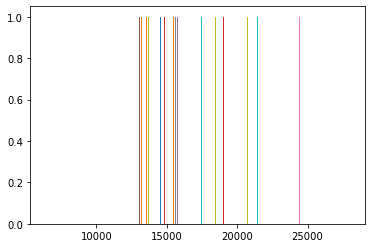

In [38]:
_ = plt.hist(hcip.to('Mbbl'), bins=20)

### For more on volumetrics and Monte Carlo simulation of prospects, along with calculating volumetrics for an entire portfolio, check out our DIGITAL GEOSCIENCE class.

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2021</p>
</div>